# Final Project

Alan Cheng, Christian Logan, Nickolas Klann, Archit Gore, John Ajani-Aldrin, Leencho Chawaka <br/>

INST447

# Data Overview


Our project focuses on analyzing traffic patterns, accident hotspots, and their potential causes in Maryland. To achieve this goal, we have gathered multiple datasets from open data sources provided by the state of Maryland. These datasets encompass various aspects of transportation and public safety, offering a comprehensive view of road-related incidents and activities <br/>

The primary datasets include:<br/>
**Maryland Annual Average Daily Traffic (AADT) Dataset**
Source: https://opendata.maryland.gov/Transportation/MD-iMAP-Maryland-Annual-Average-Daily-Traffic-Annu/ctg2-hcpq/about_data

Description: This dataset provides the most up-to-date annual traffic volume information across Maryland's roads. It serves as the foundational dataset for understanding traffic patterns and identifying high-volume areas.

**Maryland State Police Performance Dashboard**
Source: https://opendata.maryland.gov/Public-Safety/Maryland-State-Police-Performance-Dashboard-Quarte/tx73-47dk/about_data

Description: This dataset includes information on impaired driving arrests and total traffic stops conducted by the Maryland State Police on a yearly basis.

**SHIP Pedestrian Injury Rate on Public Roads**
Source: https://opendata.maryland.gov/Health-and-Human-Services/SHIP-Pedestrian-Injury-Rate-on-Public-Roads-2009-2/8iqk-udpa/about_data

Description: This dataset contains jurisdiction-wise pedestrian injury rates on public roads in Maryland for each year.

**Maryland Statewide Vehicle Crashes**
Source: https://opendata.maryland.gov/Public-Safety/Maryland-Statewide-Vehicle-Crashes-CY2015-Quarter-/x8nz-kacb/about_data

Description: This dataset comprises individual records of vehicle crashes, including details such as location, severity, and cause. It is a key dataset for analyzing accident trends, causes, and hot spots across the state.
spots across the state.

### Goal and Motivation

The overarching goal of our project is to analyze the relationships between traffic volume, accident rates, pedestrian injuries, and road characteristics in Maryland. By leveraging these datasets, we aim to identify high-risk areas and guide data-driven decision-making for targeted safety improvements and law enforcement strategies. Ultimately, our objective is to reduce accidents, save lives, and create safer roads for all Maryland residents and visitors.

# Method

We begin by importing the required libraries like pandas, numpy, matplotlib, seaborn, geopandas, and folium. We also set some display options for pandas to show all columns and prevent wrapping when printing DataFrames. We define a function called load_data_from_api to fetch data from a given URL using the requests library and convert the JSON response into a pandas DataFrame.

We load data from various CSV files and an API into separate DataFrames. We check if the files exist before loading them. We create a data cleaning function called clean_data to perform general cleaning operations like dropping rows with missing values (NaN). We apply this clean_data function to the DataFrames loaded from the files.

For the traffic data in aadt_points_data, we identify the columns representing years by looking for column names starting with "AADT_" and containing digits. We then melt (reshape) this DataFrame into a long format across the years using pd.melt. This allows us to analyze across multiple years. We also extract the actual year digits from the column names into a separate 'Year' column.

We converted the 'Year' columns to numeric data type in the aadt_points_long and pedestrian_injury_data DataFrames. Then we merged the aadt_points_long, pedestrian_injury_data, and traffic_stops_data DataFrames based on the 'Year' column to create a final_merged_data DataFrame.

From this merged DataFrame, we select specific columns and remove duplicates based on certain column combinations. We also convert the 'impaired_driving_arrests' column to integers in a filtered DataFrame called df_selected_2. We group the pedestrian_injury_data by 'year' and count the occurrences for the 'Pedestrian Injury' measure.

Finally, we create scatter plots to visualize the relationships between variables like average daily traffic (AADT) and pedestrian injuries, as well as AADT and number of lanes. For the AADT vs pedestrian injury plot.

# Preprocessing

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
import requests
from pathlib import Path
import os

In [2]:
# Configurations for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Function to load data from API
def load_data_from_api(url):
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)

# Loading data from APIs (if used)
# Example API for traffic stops
traffic_stops_url = 'https://opendata.maryland.gov/resource/tx73-47dk.json'
traffic_stops_data = load_data_from_api(traffic_stops_url)

In [4]:
traffic_stops_data.info()
traffic_stops_data.columns
traffic_stops_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   year                                  41 non-null     object
 1   quarter                               41 non-null     object
 2   quarter_and_year                      41 non-null     object
 3   medevac_missions                      41 non-null     object
 4   impaired_driving_arrests              41 non-null     object
 5   cross_border_criminal_investigations  41 non-null     object
 6   total_traffic_stops                   41 non-null     object
dtypes: object(7)
memory usage: 2.4+ KB


,year,quarter,quarter_and_year,medevac_missions,impaired_driving_arrests,cross_border_criminal_investigations,total_traffic_stops
0,2014,Q1,Q1 2014,376,1496,180,110734
1,2014,Q2,Q2 2014,597,1630,104,141940
2,2014,Q3,Q3 2014,681,1767,148,147807
3,2014,Q4,Q4 2014,484,1562,108,119741
4,2015,Q1,Q1 2015,345,1500,210,132779


In [5]:
traffic_stops_data.tail()

,year,quarter,quarter_and_year,medevac_missions,impaired_driving_arrests,cross_border_criminal_investigations,total_traffic_stops
36,2023,Q1,Q1 2023,371,1256,320,98042
37,2023,Q2,Q2 2023,543,1241,333,87591
38,2023,Q3,Q3 2023,548,1163,294,80525
39,2023,Q4,Q4 2023,437,1158,243,79072
40,2024,Q1,Q1 2024,329,1211,299,92633


In [6]:
# Define the base directory
base_dir = Path('projectdata')

# Specific files
aadt_points_file = base_dir / 'Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Points).csv'
aadt_lines_file = base_dir / 'Maryland_Annual_Average_Daily_Traffic_-_Annual_Average_Daily_Traffic_(SHA_Statewide_AADT_Lines).csv'
pedestrian_injury_file = base_dir / 'SHIP_Pedestrian_Injury_Rate_on_Public_Roads_2009-2022_20240505.csv'

In [7]:
if not aadt_points_file.exists():
    print(f"The file {aadt_points_file} does not exist!")
else:
    aadt_points_data = pd.read_csv(aadt_points_file)

if not aadt_lines_file.exists():
    print(f"The file {aadt_lines_file} does not exist!")
else:
    aadt_lines_data = pd.read_csv(aadt_lines_file)

if not pedestrian_injury_file.exists():
    print(f"The file {pedestrian_injury_file} does not exist!")
else:
    pedestrian_injury_data = pd.read_csv(pedestrian_injury_file)

C:\Users\madga\AppData\Local\Temp\ipykernel_36172\3432739259.py:4: DtypeWarning: Columns (100) have mixed types. Specify dtype option on import or set low_memory=False.
  aadt_points_data = pd.read_csv(aadt_points_file)
C:\Users\madga\AppData\Local\Temp\ipykernel_36172\3432739259.py:9: DtypeWarning: Columns (98) have mixed types. Specify dtype option on import or set low_memory=False.
  aadt_lines_data = pd.read_csv(aadt_lines_file)


In [8]:
aadt_points_data = pd.read_csv(aadt_points_file)
aadt_lines_data = pd.read_csv(aadt_lines_file)
pedestrian_injury_data = pd.read_csv(pedestrian_injury_file)

C:\Users\madga\AppData\Local\Temp\ipykernel_36172\3372450109.py:1: DtypeWarning: Columns (100) have mixed types. Specify dtype option on import or set low_memory=False.
  aadt_points_data = pd.read_csv(aadt_points_file)
C:\Users\madga\AppData\Local\Temp\ipykernel_36172\3372450109.py:2: DtypeWarning: Columns (98) have mixed types. Specify dtype option on import or set low_memory=False.
  aadt_lines_data = pd.read_csv(aadt_lines_file)


## Cleaning

In [9]:
# General cleaning for all datasets
def clean_data(df):
    # Example: Convert dates, handle missing values
    df.dropna(inplace=True)
    return df

aadt_points_data = clean_data(aadt_points_data)
aadt_lines_data = clean_data(aadt_lines_data)
pedestrian_injury_data = clean_data(pedestrian_injury_data)

In [10]:
aadt_lines_data.info()
aadt_lines_data.columns
aadt_lines_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 46 to 4658
Columns: 102 entries, OBJECTID to Shape_Length
dtypes: float64(52), int64(11), object(39)
memory usage: 150.5+ KB


,OBJECTID,LOCATION_ID,COUNTY_ID,COUNTY_DESC,MUN_SORT,MUNICIPALITY,ROADNAME,ID_PREFIX,ID_RTE_NO,MP_SUFFIX,ID_MP,BEGIN_SECTION,END_SECTION,STATION_DESC,ROAD_SECTION,RURAL_URBAN,F_SYSTEM,F_SYSTEM_DESC,ROUTEID,ROUTEID_RH,MAIN_LINE,PEAK_HOUR_DIRECTION,NUM_LANES,COUNTED_FACTORED,STMP_SEQ,K_FACTOR,D_FACTOR,NORTH_EAST_SPLIT,SOUTH_WEST_SPLIT,AVMT,LINK,AADT_2010,AADT_2011,AADT_2012,AADT_2013,AADT_2014,AADT_2015,AADT_2016,AADT_2017,AADT_2018,AADT,AAWDT_2010,AAWDT_2011,AAWDT_2012,AAWDT_2013,AAWDT_2014,AAWDT_2015,AAWDT_2016,AAWDT_2017,AAWDT_2018,AAWDT,MOTORCYCLE_AADT,CAR_AADT,LIGHT_TRUCK_AADT,BUS_AADT,SINGLE_UNIT_AADT,COMBINATION_UNIT_AADT,LOC_ERROR,Shape_Length0,TRUCK_AADT,SUTRUCK_AADT_PCT_TRUCK,CUTRUCK_AADT_PCT_TRUCK,MCYCLE_AADT_PCT_OVERALL,CAR_AADT_PCT_OVERALL,LIGHT_TRUCK_AADT_PCT_OVERALL,BUS_AADT_PCT_OVERALL,SUTRUCK_AADT_PCT_OVERALL,CUTRUCK_AADT_PCT_OVERALL,TRUCK_AADT_PCT_OVERALL,NUM_LANES_ANNO,K_FACTOR_ANNO,D_FACTOR_ANNO,NORTH_EAST_SPLIT_ANNO,SOUTH_WEST_SPLIT_ANNO,AADT_2010_ANNO,AADT_2011_ANNO,AADT_2012_ANNO,AADT_2013_ANNO,AADT_2014_ANNO,AADT_2015_ANNO,AADT_2016_ANNO,AADT_2017_ANNO,AADT_2018_ANNO,AADT_ANNO,AAWDT_2010_ANNO,AAWDT_2011_ANNO,AAWDT_2012_ANNO,AAWDT_2013_ANNO,AAWDT_2014_ANNO,AAWDT_2015_ANNO,AAWDT_2016_ANNO,AAWDT_2017_ANNO,AAWDT_2018_ANNO,AAWDT_ANNO,MOTORCYCLE_AADT_ANNO,CAR_AADT_ANNO,BUS_AADT_ANNO,LIGHT_TRUCK_AADT_ANNO,SINGLE_UNIT_AADT_ANNO,COMBINATION_UNIT_AADT_ANNO,TRUCK_AADT_ANNO,Shape_Length
46,47,B060073,6,Carroll,155,Westminster,E Green St,MU,210,,0.23,0.17,0.98,Green St E&w-between Washington Rd & Bishop St,Washington Rd To Md 27,Urban,4,Minor Arterial,06155MU00210 01NN**************,06155MU00210--1-----,1,South,2,C,0,8.87,56.13,52.30,47.70,1.5226,https://maps.roads.maryland.gov/itms_public/?s...,5520.0,5541.0,5502.0,4960.0,4951.0,5082.0,4910.0,5031.0,4992.0,5150,5910.0,5981.0,5942.0,5360.0,5301.0,5442.0,5250.0,5381.0,5342.0,5460,8.0,4287.0,705.0,10.0,130.0,10.0,NO ERROR,4215.520094,140.0,0.928571,0.071429,0.001553,0.832427,0.136893,0.001942,0.025243,0.001942,0.027184,2,8.87,56.13,52.30,47.70,"5,520","5,541","5,502","4,960","4,951","5,082","4,910","5,031","4,992","5,150","5,910","5,981","5,942","5,360","5,301","5,442","5,250","5,381","5,342","5,460",8.0,"4,287",10.0,705,130,10.0,140.0,1668.612144
84,85,B020046,2,Anne Arundel,3,Annapolis,Tyler Ave,MU,3220,,0.37,0.27,1.21,Tyler Ave-.10 Mi N Of Bay Ridge Ave,Bay Ridge Ave To Forest Dr,Urban,6,Minor Collector,02003MU03220 01NN**************,02003MU03220--1-----,1,North,3,F,0,8.19,54.66,56.11,43.89,3.8743,https://maps.roads.maryland.gov/itms_public/?s...,11692.0,11300.0,11211.0,11232.0,11680.0,11981.0,12212.0,11390.0,11291.0,11292,12512.0,12200.0,12111.0,12132.0,12500.0,12821.0,13072.0,12070.0,11971.0,12422,43.0,9228.0,1645.0,8.0,265.0,103.0,NO ERROR,4851.762379,368.0,0.720109,0.279891,0.003808,0.817216,0.145678,0.000708,0.023468,0.009121,0.032589,3,8.19,54.66,56.11,43.89,"11,692","11,300","11,211","11,232","11,680","11,981","12,212","11,390","11,291","11,292","12,512","12,200","12,111","12,132","12,500","12,821","13,072","12,070","11,971","12,422",43.0,"9,228",8.0,"1,645",265,103.0,368.0,1901.366299
188,189,B060072,6,Carroll,155,Westminster,Anchor St,MU,10,,0.05,0.00,0.08,Anchor St-between W. Main St & W. Green St (on...,W. Main St To W. Green St,Urban,4,Minor Arterial,06155MU00010 01SS**************,06155MU00010--1-----,1,South,1,C,0,7.93,100.00,0.00,100.00,0.0356,https://maps.roads.maryland.gov/itms_public/?s...,1140.0,1151.0,1142.0,1100.0,1101.0,1132.0,1170.0,1201.0,1192.0,1220,1220.0,1241.0,1232.0,1190.0,1181.0,1212.0,1250.0,1291.0,1282.0,1290,4.0,965.0,180.0,3.0,58.0,10.0,NO ERROR,469.215742,68.0,0.852941,0.147059,0.003279,0.790984,0.147541,0.002459,0.047541,0.008197,0.055738,1,7.93,100.00,0.00,100.00,"1,140","1,151","1,142","1,100","1,101","1,132","1,170","1,201","1,192","1,220","1,220","1,241","1,232","1,190","1,181","1,212","1,250","1,291","1,282","1,290",4.0,965,3.0,180,58,10.0,68.0,185.598061
261,262,B010016,1,Allegany,41,Cumberland,Bedford St,MU,270,,0.73,0.14,2

In [11]:
aadt_points_data.info()
aadt_points_data.columns
aadt_points_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 9 to 3008
Columns: 102 entries, X to TRUCK_AADT_ANNO
dtypes: float64(49), int64(11), object(42)
memory usage: 70.8+ KB


,X,Y,OBJECTID,LOCATION_ID,COUNTY_ID,COUNTY_DESC,MUN_SORT,MUNICIPALITY,ROADNAME,ID_PREFIX,ID_RTE_NO,MP_SUFFIX,ID_MP,BEGIN_SECTION,END_SECTION,STATION_DESC,ROAD_SECTION,RURAL_URBAN,F_SYSTEM,F_SYSTEM_DESC,ROUTEID,ROUTEID_RH,MAIN_LINE,PEAK_HOUR_DIRECTION,NUM_LANES,COUNTED_FACTORED,STMP_SEQ,K_FACTOR,D_FACTOR,NORTH_EAST_SPLIT,SOUTH_WEST_SPLIT,AVMT,LINK,AADT_2010,AADT_2011,AADT_2012,AADT_2013,AADT_2014,AADT_2015,AADT_2016,AADT_2017,AADT_2018,AADT,AAWDT_2010,AAWDT_2011,AAWDT_2012,AAWDT_2013,AAWDT_2014,AAWDT_2015,AAWDT_2016,AAWDT_2017,AAWDT_2018,AAWDT,MOTORCYCLE_AADT,CAR_AADT,LIGHT_TRUCK_AADT,BUS_AADT,SINGLE_UNIT_AADT,COMBINATION_UNIT_AADT,LOC_ERROR,TRUCK_AADT,SUTRUCK_AADT_PCT_TRUCK,CUTRUCK__AADT_PCT_TRUCK,MCYCLE_AADT_PCT_OVERALL,CAR_AADT_PCT_OVERALL,LIGHT_TRUCK_AADT_PCT_OVERALL,BUS_AADT_PCT_OVERALL,SUTRUCK_AADT_PCT_OVERALL,CUTRUCK_AADT_PCT_OVERALL,TRUCK_AADT_PCT_OVERALL,NUM_LANES_ANNO,K_FACTOR_ANNO,D_FACTOR_ANNO,NORTH_EAST_SPLIT_ANNO,SOUTH_WEST_SPLIT_ANNO,AADT_2010_ANNO,AADT_2011_ANNO,AADT_2012_ANNO,AADT_2013_ANNO,AADT_2014_ANNO,AADT_2015_ANNO,AADT_2016_ANNO,AADT_2017_ANNO,AADT_2018_ANNO,AADT_ANNO,AAWDT_2010_ANNO,AAWDT_2011_ANNO,AAWDT_2012_ANNO,AAWDT_2013_ANNO,AAWDT_2014_ANNO,AAWDT_2015_ANNO,AAWDT_2016_ANNO,AAWDT_2017_ANNO,AAWDT_2018_ANNO,AAWDT_ANNO,MOTORCYCLE_AADT_ANNO,CAR_AADT_ANNO,BUS_AADT_ANNO,LIGHT_TRUCK_AADT_ANNO,SINGLE_UNIT_AADT_ANNO,COMBINATION_UNIT_AADT_ANNO,TRUCK_AADT_ANNO
9,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.00,0.44,E Second St-.between Arch St & Grand Ave (one ...,Virginia Ave To Memorial Ave,Urban,6,Minor Collector,01041MU03210 01EE**************,01041MU03210--1-----,1,East,2,F,0,9.41,100.00,100.00,0.00,0.0790,https://maps.roads.maryland.gov/itms_public/?s...,1045.0,950.0,941.0,942.0,500.0,511.0,522.0,490.0,491.0,492,1105.0,1030.0,1021.0,1022.0,540.0,551.0,562.0,520.0,521.0,542,16.0,409.0,62.0,2.0,3.0,0.0,NO ERROR,3.0,1.000000,0.000000,0.032520,0.831301,0.126016,0.004065,0.006098,0.000000,0.006098,2,9.41,100.00,100.00,0.00,"1,045",950,941,942,500,511,522,490,491,492,"1,105","1,030","1,021","1,022",540,551,562,520,521,542,16.0,409,2,62,3,0,3
59,-8.470538e+06,4.661852e+06,60,B090013,9,Dorchester,19,Cambridge,Glasgow St,MU,520,,0.10,0.00,1.15,Glasgow St-.10 Mi S Of Hambrooks Blvd,Hambrooks Blvd To High St,Urban,5,Major Collector,09019MU00520 01SS**************,09019MU00520--1-----,1,North,2,F,0,9.01,61.69,47.89,52.11,1.0582,https://maps.roads.maryland.gov/itms_public/?s...,4931.0,4952.0,2510.0,2521.0,2512.0,2720.0,2771.0,2842.0,2520.0,2521,5281.0,5352.0,2710.0,2721.0,2692.0,2910.0,2971.0,3042.0,2700.0,2671,7.0,1871.0,492.0,8.0,127.0,16.0,NO ERROR,143.0,0.888112,0.111888,0.002777,0.742166,0.195161,0.003173,0.050377,0.006347,0.056724,2,9.01,61.69,47.89,52.11,"4,931","4,952","2,510","2,521","2,512","2,720","2,771","2,842","2,520","2,521","5,281","5,352","2,710","2,721","2,692","2,910","2,971","3,042","2,700","2,671",7.0,"1,871",8,492,127,16,143
79,-8.622809e+06,4.782320e+06,80,B100065,10,Frederick,57,Frederick,Waverley Dr,MU,1545,,0.20,0.00,0.78,Waverley Dr-.20 Mi N Of Us40,Us 40 To Shookstown Rd,Urban,6,Minor Collector,10057MU01545 01NN**************,10057MU01545--1-----,1,South,3,F,0,9.25,51.12,49.65,50.35,1.3928,https://maps.roads.maryland.gov/itms_public/?s...,5552.0,5810.0,5761.0,5772.0,4850.0,4981.0,5082.0,4930.0,4891.0,4892,5942.0,6280.0,6221.0,6232.0,5190.0,5331.0,5442.0,5230.0,5181.0,5382,43.0,3926.0,588.0,22.0,288.0,25.0,NO ERROR,313.0,0.920128,0.079872,0.008790,0.802535,0.120196,0.004497,0.058872,0.005110,0.063982,3,9.25,51.12,49.65,50.35,"5,552","5,810","5,761","5,772","4,850","4,981","5,082","4,930","4,891","4,892","5,942","6,280","6,221","6,232","5,190","5,331","5,442","5,230","5,181","5,382",43.0,"3,926",22,588,288,25,313
116,-8.519905e+06,4.718421e+06,117,B0767,2,Anne Arundel,3,Annapolis,Forest Dr,MU,1165,,0.56,0.36,1.21,Forest Dr-.10 Mi E Of Md393,Md 2 To Fairfax Rd,Urban,5,Major Collector,02003MU01165 01SS**************,02003MU01165--1-----,1,East,3,C,0,7

In [12]:
pedestrian_injury_data.info()
pedestrian_injury_data.columns
pedestrian_injury_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 349
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Jurisdiction     268 non-null    object 
 1   Value            268 non-null    float64
 2   Race/ ethnicity  268 non-null    object 
 3   Year             268 non-null    int64  
 4   Measure          268 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 12.6+ KB


,Jurisdiction,Value,Race/ ethnicity,Year,Measure
0,State,53.5,All races/ ethnicities (aggregated),2017,Pedestrian Injury
2,Anne Arundel,37.3,All races/ ethnicities (aggregated),2017,Pedestrian Injury
3,Baltimore City,183.4,All races/ ethnicities (aggregated),2017,Pedestrian Injury
4,Baltimore County,54.4,All races/ ethnicities (aggregated),2017,Pedestrian Injury
7,Carroll,11.9,All races/ ethnicities (aggregated),2017,Pedestrian Injury


## Merging

In [13]:
# Identify columns representing years
points_year_columns = [col for col in aadt_points_data.columns if col.startswith('AADT_')]
points_year_columns_numeric = [col for col in points_year_columns if col.replace('AADT_', '').isdigit()]

In [14]:
# Melt the data to long format correctly
id_vars = [col for col in aadt_points_data.columns if col not in points_year_columns_numeric]

In [15]:
aadt_points_long = pd.melt(aadt_points_data, id_vars=id_vars, var_name='Year', value_name='AADT_points_year_value',
                    value_vars=points_year_columns_numeric)

In [16]:
# Correctly extracting the year from the 'Year' column
aadt_points_long['Year'] = aadt_points_long['Year'].str.replace('AADT_', '').astype(int)

# Print the first few rows of the resulting DataFrame to check the transformation
aadt_points_long.head()

,X,Y,OBJECTID,LOCATION_ID,COUNTY_ID,COUNTY_DESC,MUN_SORT,MUNICIPALITY,ROADNAME,ID_PREFIX,ID_RTE_NO,MP_SUFFIX,ID_MP,BEGIN_SECTION,END_SECTION,STATION_DESC,ROAD_SECTION,RURAL_URBAN,F_SYSTEM,F_SYSTEM_DESC,ROUTEID,ROUTEID_RH,MAIN_LINE,PEAK_HOUR_DIRECTION,NUM_LANES,COUNTED_FACTORED,STMP_SEQ,K_FACTOR,D_FACTOR,NORTH_EAST_SPLIT,SOUTH_WEST_SPLIT,AVMT,LINK,AADT,AAWDT_2010,AAWDT_2011,AAWDT_2012,AAWDT_2013,AAWDT_2014,AAWDT_2015,AAWDT_2016,AAWDT_2017,AAWDT_2018,AAWDT,MOTORCYCLE_AADT,CAR_AADT,LIGHT_TRUCK_AADT,BUS_AADT,SINGLE_UNIT_AADT,COMBINATION_UNIT_AADT,LOC_ERROR,TRUCK_AADT,SUTRUCK_AADT_PCT_TRUCK,CUTRUCK__AADT_PCT_TRUCK,MCYCLE_AADT_PCT_OVERALL,CAR_AADT_PCT_OVERALL,LIGHT_TRUCK_AADT_PCT_OVERALL,BUS_AADT_PCT_OVERALL,SUTRUCK_AADT_PCT_OVERALL,CUTRUCK_AADT_PCT_OVERALL,TRUCK_AADT_PCT_OVERALL,NUM_LANES_ANNO,K_FACTOR_ANNO,D_FACTOR_ANNO,NORTH_EAST_SPLIT_ANNO,SOUTH_WEST_SPLIT_ANNO,AADT_2010_ANNO,AADT_2011_ANNO,AADT_2012_ANNO,AADT_2013_ANNO,AADT_2014_ANNO,AADT_2015_ANNO,AADT_2016_ANNO,AADT_2017_ANNO,AADT_2018_ANNO,AADT_ANNO,AAWDT_2010_ANNO,AAWDT_2011_ANNO,AAWDT_2012_ANNO,AAWDT_2013_ANNO,AAWDT_2014_ANNO,AAWDT_2015_ANNO,AAWDT_2016_ANNO,AAWDT_2017_ANNO,AAWDT_2018_ANNO,AAWDT_ANNO,MOTORCYCLE_AADT_ANNO,CAR_AADT_ANNO,BUS_AADT_ANNO,LIGHT_TRUCK_AADT_ANNO,SINGLE_UNIT_AADT_ANNO,COMBINATION_UNIT_AADT_ANNO,TRUCK_AADT_ANNO,Year,AADT_points_year_value
0,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.00,0.44,E Second St-.between Arch St & Grand Ave (one ...,Virginia Ave To Memorial Ave,Urban,6,Minor Collector,01041MU03210 01EE**************,01041MU03210--1-----,1,East,2,F,0,9.41,100.00,100.00,0.00,0.0790,https://maps.roads.maryland.gov/itms_public/?s...,492,1105.0,1030.0,1021.0,1022.0,540.0,551.0,562.0,520.0,521.0,542,16.0,409.0,62.0,2.0,3.0,0.0,NO ERROR,3.0,1.000000,0.000000,0.032520,0.831301,0.126016,0.004065,0.006098,0.000000,0.006098,2,9.41,100.00,100.00,0.00,"1,045",950,941,942,500,511,522,490,491,492,"1,105","1,030","1,021","1,022",540,551,562,520,521,542,16.0,409,2,62,3,0,3,2010,1045.0
1,-8.470538e+06,4.661852e+06,60,B090013,9,Dorchester,19,Cambridge,Glasgow St,MU,520,,0.10,0.00,1.15,Glasgow St-.10 Mi S Of Hambrooks Blvd,Hambrooks Blvd To High St,Urban,5,Major Collector,09019MU00520 01SS**************,09019MU00520--1-----,1,North,2,F,0,9.01,61.69,47.89,52.11,1.0582,https://maps.roads.maryland.gov/itms_public/?s...,2521,5281.0,5352.0,2710.0,2721.0,2692.0,2910.0,2971.0,3042.0,2700.0,2671,7.0,1871.0,492.0,8.0,127.0,16.0,NO ERROR,143.0,0.888112,0.111888,0.002777,0.742166,0.195161,0.003173,0.050377,0.006347,0.056724,2,9.01,61.69,47.89,52.11,"4,931","4,952","2,510","2,521","2,512","2,720","2,771","2,842","2,520","2,521","5,281","5,352","2,710","2,721","2,692","2,910","2,971","3,042","2,700","2,671",7.0,"1,871",8,492,127,16,143,2010,4931.0
2,-8.622809e+06,4.782320e+06,80,B100065,10,Frederick,57,Frederick,Waverley Dr,MU,1545,,0.20,0.00,0.78,Waverley Dr-.20 Mi N Of Us40,Us 40 To Shookstown Rd,Urban,6,Minor Collector,10057MU01545 01NN**************,10057MU01545--1-----,1,South,3,F,0,9.25,51.12,49.65,50.35,1.3928,https://maps.roads.maryland.gov/itms_public/?s...,4892,5942.0,6280.0,6221.0,6232.0,5190.0,5331.0,5442.0,5230.0,5181.0,5382,43.0,3926.0,588.0,22.0,288.0,25.0,NO ERROR,313.0,0.920128,0.079872,0.008790,0.802535,0.120196,0.004497,0.058872,0.005110,0.063982,3,9.25,51.12,49.65,50.35,"5,552","5,810","5,761","5,772","4,850","4,981","5,082","4,930","4,891","4,892","5,942","6,280","6,221","6,232","5,190","5,331","5,442","5,230","5,181","5,382",43.0,"3,926",22,588,288,25,313,2010,5552.0
3,-8.519905e+06,4.718421e+06,117,B0767,2,Anne Arundel,3,Annapolis,Forest Dr,MU,1165,,0.56,0.36,1.21,Forest Dr-.10 Mi E Of Md393,Md 2 To Fairfax Rd,Urban,5,Major Collector,02003MU01165 01SS**************,02003MU01165--1-----,1,East,3,C,0,7.66,52.77,48.15,51.85,3.0280,https://maps.roads.maryland.gov/itms_public/?s...,9760,11590.0,11741.0,11652.0,10340.0,10211.0,10482.0,10230.0,10381.0,10282.0,10740,10.0,8724.0,857.0,8.0,132.0,29.0,NO ERROR,161.0,0

In [17]:
try:
    aadt_points_long['Year'] = aadt_points_long['Year'].astype(int)
except ValueError as e:
    print(f"Error converting Year: {e}")

In [18]:
pedestrian_injury_data['Year'] = pedestrian_injury_data['Year'].astype(int)

In [19]:
traffic_stops_data.rename(columns={'year': 'Year'}, inplace=True)
traffic_stops_data['year'] = traffic_stops_data['Year'].astype(int)

traffic_stops_data.info()
traffic_stops_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Year                                  41 non-null     object
 1   quarter                               41 non-null     object
 2   quarter_and_year                      41 non-null     object
 3   medevac_missions                      41 non-null     object
 4   impaired_driving_arrests              41 non-null     object
 5   cross_border_criminal_investigations  41 non-null     object
 6   total_traffic_stops                   41 non-null     object
 7   year                                  41 non-null     int32 
dtypes: int32(1), object(7)
memory usage: 2.5+ KB


,Year,quarter,quarter_and_year,medevac_missions,impaired_driving_arrests,cross_border_criminal_investigations,total_traffic_stops,year
0,2014,Q1,Q1 2014,376,1496,180,110734,2014
1,2014,Q2,Q2 2014,597,1630,104,141940,2014
2,2014,Q3,Q3 2014,681,1767,148,147807,2014
3,2014,Q4,Q4 2014,484,1562,108,119741,2014
4,2015,Q1,Q1 2015,345,1500,210,132779,2015


In [20]:
# Merge the reshaped traffic data with pedestrian data
combined_data = pd.merge(aadt_points_long, pedestrian_injury_data, on='Year', how='inner')

In [21]:
# Now merge the combined data with traffic stops data
final_merged_data = pd.merge(combined_data, traffic_stops_data, left_on='Year', right_on='year', how='inner')

In [22]:
final_merged_data.head()

,X,Y,OBJECTID,LOCATION_ID,COUNTY_ID,COUNTY_DESC,MUN_SORT,MUNICIPALITY,ROADNAME,ID_PREFIX,ID_RTE_NO,MP_SUFFIX,ID_MP,BEGIN_SECTION,END_SECTION,STATION_DESC,ROAD_SECTION,RURAL_URBAN,F_SYSTEM,F_SYSTEM_DESC,ROUTEID,ROUTEID_RH,MAIN_LINE,PEAK_HOUR_DIRECTION,NUM_LANES,COUNTED_FACTORED,STMP_SEQ,K_FACTOR,D_FACTOR,NORTH_EAST_SPLIT,SOUTH_WEST_SPLIT,AVMT,LINK,AADT,AAWDT_2010,AAWDT_2011,AAWDT_2012,AAWDT_2013,AAWDT_2014,AAWDT_2015,AAWDT_2016,AAWDT_2017,AAWDT_2018,AAWDT,MOTORCYCLE_AADT,CAR_AADT,LIGHT_TRUCK_AADT,BUS_AADT,SINGLE_UNIT_AADT,COMBINATION_UNIT_AADT,LOC_ERROR,TRUCK_AADT,SUTRUCK_AADT_PCT_TRUCK,CUTRUCK__AADT_PCT_TRUCK,MCYCLE_AADT_PCT_OVERALL,CAR_AADT_PCT_OVERALL,LIGHT_TRUCK_AADT_PCT_OVERALL,BUS_AADT_PCT_OVERALL,SUTRUCK_AADT_PCT_OVERALL,CUTRUCK_AADT_PCT_OVERALL,TRUCK_AADT_PCT_OVERALL,NUM_LANES_ANNO,K_FACTOR_ANNO,D_FACTOR_ANNO,NORTH_EAST_SPLIT_ANNO,SOUTH_WEST_SPLIT_ANNO,AADT_2010_ANNO,AADT_2011_ANNO,AADT_2012_ANNO,AADT_2013_ANNO,AADT_2014_ANNO,AADT_2015_ANNO,AADT_2016_ANNO,AADT_2017_ANNO,AADT_2018_ANNO,AADT_ANNO,AAWDT_2010_ANNO,AAWDT_2011_ANNO,AAWDT_2012_ANNO,AAWDT_2013_ANNO,AAWDT_2014_ANNO,AAWDT_2015_ANNO,AAWDT_2016_ANNO,AAWDT_2017_ANNO,AAWDT_2018_ANNO,AAWDT_ANNO,MOTORCYCLE_AADT_ANNO,CAR_AADT_ANNO,BUS_AADT_ANNO,LIGHT_TRUCK_AADT_ANNO,SINGLE_UNIT_AADT_ANNO,COMBINATION_UNIT_AADT_ANNO,TRUCK_AADT_ANNO,Year_x,AADT_points_year_value,Jurisdiction,Value,Race/ ethnicity,Measure,Year_y,quarter,quarter_and_year,medevac_missions,impaired_driving_arrests,cross_border_criminal_investigations,total_traffic_stops,year
0,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.0,0.44,E Second St-.between Arch St & Grand Ave (one ...,Virginia Ave To Memorial Ave,Urban,6,Minor Collector,01041MU03210 01EE**************,01041MU03210--1-----,1,East,2,F,0,9.41,100.0,100.0,0.0,0.079,https://maps.roads.maryland.gov/itms_public/?s...,492,1105.0,1030.0,1021.0,1022.0,540.0,551.0,562.0,520.0,521.0,542,16.0,409.0,62.0,2.0,3.0,0.0,NO ERROR,3.0,1.0,0.0,0.03252,0.831301,0.126016,0.004065,0.006098,0.0,0.006098,2,9.41,100.0,100.0,0.0,"1,045",950,941,942,500,511,522,490,491,492,"1,105","1,030","1,021","1,022",540,551,562,520,521,542,16.0,409,2,62,3,0,3,2014,500.0,State,42.6,All races/ ethnicities (aggregated),Pedestrian Injury,2014,Q1,Q1 2014,376,1496,180,110734,2014
1,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.0,0.44,E Second St-.between Arch St & Grand Ave (one ...,Virginia Ave To Memorial Ave,Urban,6,Minor Collector,01041MU03210 01EE**************,01041MU03210--1-----,1,East,2,F,0,9.41,100.0,100.0,0.0,0.079,https://maps.roads.maryland.gov/itms_public/?s...,492,1105.0,1030.0,1021.0,1022.0,540.0,551.0,562.0,520.0,521.0,542,16.0,409.0,62.0,2.0,3.0,0.0,NO ERROR,3.0,1.0,0.0,0.03252,0.831301,0.126016,0.004065,0.006098,0.0,0.006098,2,9.41,100.0,100.0,0.0,"1,045",950,941,942,500,511,522,490,491,492,"1,105","1,030","1,021","1,022",540,551,562,520,521,542,16.0,409,2,62,3,0,3,2014,500.0,State,42.6,All races/ ethnicities (aggregated),Pedestrian Injury,2014,Q2,Q2 2014,597,1630,104,141940,2014
2,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.0,0.44,E Second St-.between Arch St & Grand Ave (one ...,Virginia Ave To Memorial Ave,Urban,6,Minor Collector,01041MU03210 01EE**************,01041MU03210--1-----,1,East,2,F,0,9.41,100.0,100.0,0.0,0.079,https://maps.roads.maryland.gov/itms_public/?s...,492,1105.0,1030.0,1021.0,1022.0,540.0,551.0,562.0,520.0,521.0,542,16.0,409.0,62.0,2.0,3.0,0.0,NO ERROR,3.0,1.0,0.0,0.03252,0.831301,0.126016,0.004065,0.006098,0.0,0.006098,2,9.41,100.0,100.0,0.0,"1,045",950,941,942,500,511,522,490,491,492,"1,105","1,030","1,021","1,022",540,551,562,520,521,542,16.0,409,2,62,3,0,3,2014,500.0,State,42.6,All races/ ethnicities (aggregated),Pedestrian Injury,2014,Q3,Q3 2014,681,1767,148,147807,2014
3,-8.767689e+06,4.813219e+06,10,B010029,1,Allegany,41,Cumberland,E Second St,MU,3210,,0.07,0.0,0.44,E Second St-.between Arch St & Grand Ave (one ...

# Results

### Annual Average Daily Traffic by County From 2014-2018

In [23]:
selected_columns = ['COUNTY_DESC', 'AADT', 'AAWDT', 'year']
df_selected = final_merged_data.loc[:, selected_columns]

# Keep only rows with unique combinations of 'COUNTY_DESC' and 'year'
df_unique = df_selected.drop_duplicates(subset=['COUNTY_DESC', 'year'])

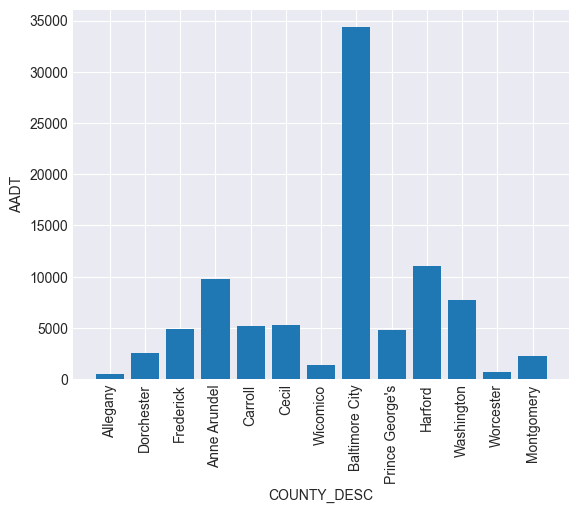

In [37]:
plt.xlabel('COUNTY_DESC')
plt.ylabel('AADT')
plt.bar(df_unique['COUNTY_DESC'], df_unique['AADT'])
plt.xticks(rotation=90)
plt.show()

### Annual Impaired Driving Arrests by Year

In [25]:
selected_columns_2 = ['quarter_and_year', 'quarter', 'year', 'impaired_driving_arrests']
df_selected_2 = final_merged_data.loc[:, selected_columns_2]

# Drop rows with repeating values in 'quarter_and_year', 'quarter', and 'year'
df_selected_2 = df_selected_2.drop_duplicates(subset=['quarter_and_year', 'quarter', 'year'])

# Convert 'impaired_driving_arrests' column to integers
df_selected_2['impaired_driving_arrests'] = df_selected_2['impaired_driving_arrests'].astype(int)

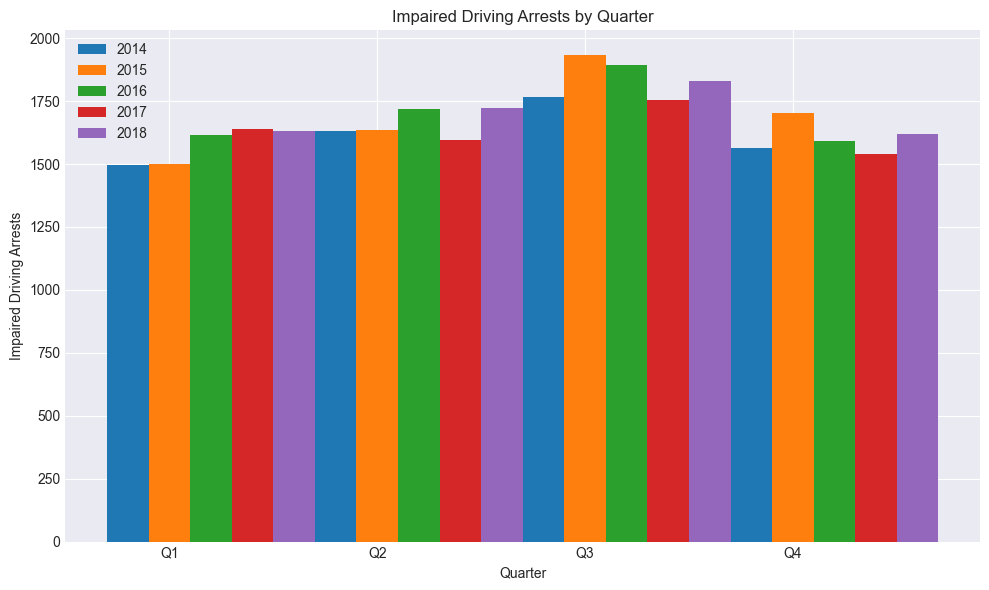

In [40]:
years = df_selected_2['year'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

for i, year in enumerate(years):
    data_year = df_selected_2[df_selected_2['year'] == year]
    
    x_positions = [j + i * 0.2 for j in range(len(data_year['quarter']))]
    
    ax.bar(x_positions, data_year['impaired_driving_arrests'], width=0.2, label=year)

ax.set_xticks([i + 0.2 for i in range(len(data_year['quarter']))])
ax.set_xticklabels(data_year['quarter'])
ax.set_xlabel('Quarter')
ax.set_ylabel('Impaired Driving Arrests')
ax.set_title('Impaired Driving Arrests by Quarter')

ax.legend()
plt.tight_layout()
plt.show()

### Pedestrian Injuries

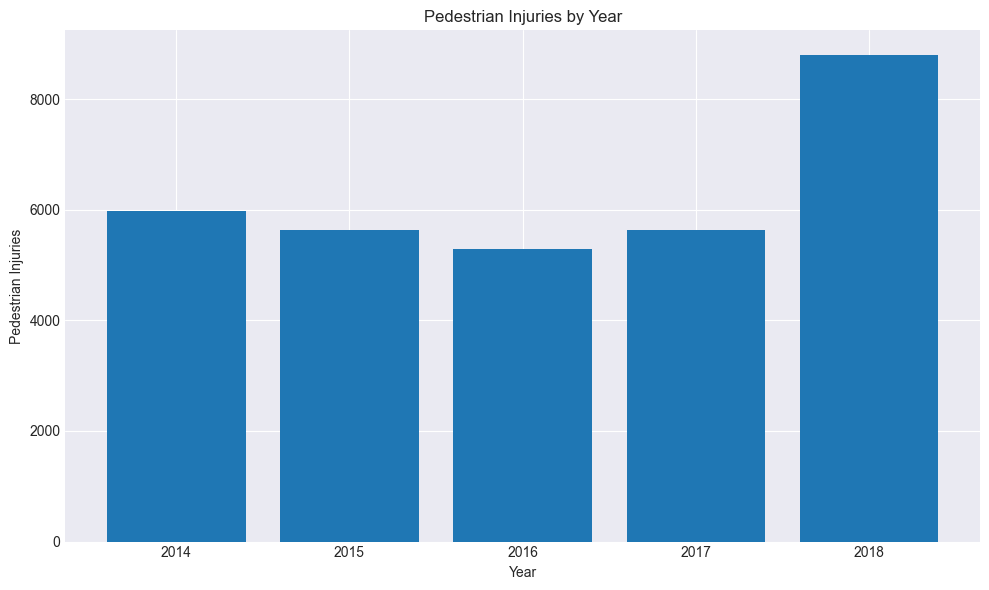

In [44]:
pedestrian_injury_data = final_merged_data[['year', 'Measure']]
pedestrian_injury_data = pedestrian_injury_data[pedestrian_injury_data['Measure'] == 'Pedestrian Injury']

grouped_data = pedestrian_injury_data.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(grouped_data['year'], grouped_data['count'])

plt.xlabel('Year')
plt.ylabel('Pedestrian Injuries')
plt.title('Pedestrian Injuries by Year')
plt.tight_layout()
plt.show()

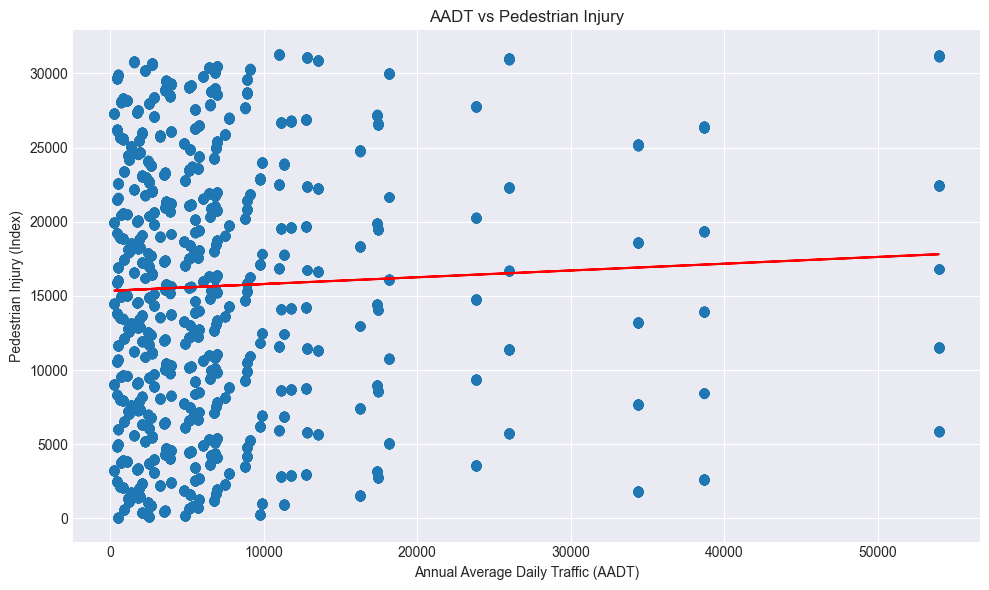

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_merged_df contains your data

# Filter relevant columns and rows where Measure is 'Pedestrian Injury'
pedestrian_injury_data = final_merged_data[['AADT', 'Measure']]
pedestrian_injury_data = pedestrian_injury_data[pedestrian_injury_data['Measure'] == 'Pedestrian Injury']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pedestrian_injury_data['AADT'], pedestrian_injury_data.index, alpha=0.5)

# Adding labels and title
plt.xlabel('Annual Average Daily Traffic (AADT)')
plt.ylabel('Pedestrian Injury (Index)')
plt.title('AADT vs Pedestrian Injury')

# Adding trend line
z = np.polyfit(pedestrian_injury_data['AADT'], pedestrian_injury_data.index, 1)
p = np.poly1d(z)
plt.plot(pedestrian_injury_data['AADT'], p(pedestrian_injury_data['AADT']), color='red')

plt.grid(True)
plt.tight_layout()
plt.show()

### AADT by Number of Lanes

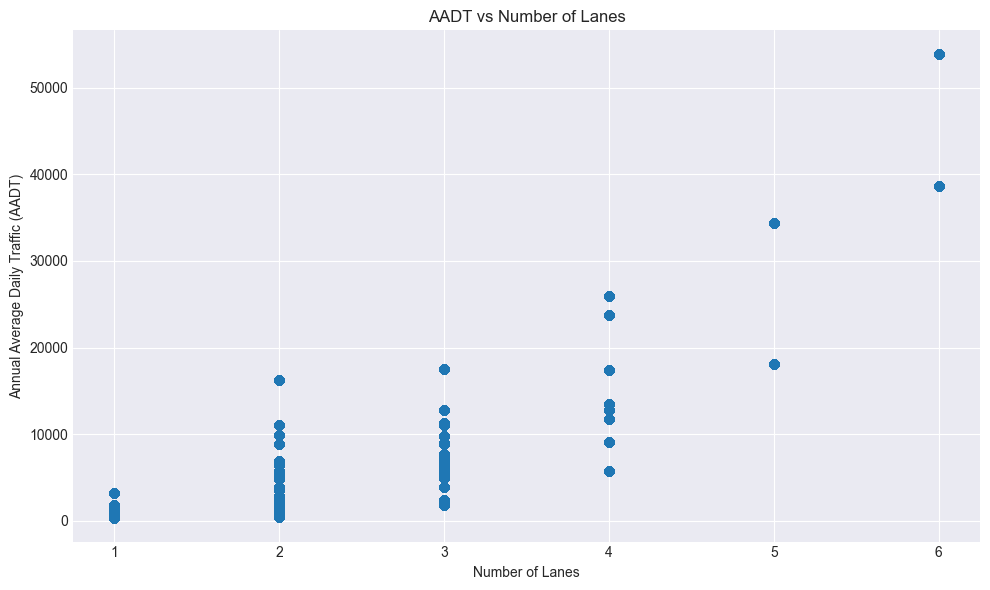

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_merged_df contains your data

# Filter relevant columns
df_selected = final_merged_data[['AADT', 'NUM_LANES']]

# Remove rows with missing data in either AADT or NUM_LANES column
df_selected = df_selected.dropna(subset=['AADT', 'NUM_LANES'])

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['NUM_LANES'], df_selected['AADT'], alpha=0.5)

# Adding labels and title
plt.xlabel('Number of Lanes')
plt.ylabel('Annual Average Daily Traffic (AADT)')
plt.title('AADT vs Number of Lanes')
plt.grid(True)
plt.tight_layout()
plt.show()

# Limitations

During the collection of the datasets that we wanted to use, there were a few limitations that we ran into. The main thing was finding multiple datasets where the years would match up and we could analyze those datasets together. Another limitation regarding that would mean that we would only be able to analyze data for a specific year or two and finding the datasets for the information we need severly limited which ones we could use.

After figuring out what datasets that we needed, those datasets limited our information to just Maryland and the data that was provided by Maryland.gov. This was our intention as we wanted to limit it to a smaller area but also one that was relevant to us. This means that the findings or take away that we get from this project would only apply to Maryland and not represent a larger area of America.

Also, with what datasets we are deciding to use, there are characteristics that we ultimately do not have where the information may be useful, its not necessary. Some of the information that we do not have would include: Weather, Road conditions/Construction and Demographics.

Finally, we create scatter plots to visualize the relationships between variables like average daily traffic (AADT) and pedestrian injuries, as well as AADT and number of lanes. For the AADT vs pedestrian injury plot.

# Discussion

Through the analysis of our data, we found lots of interesting information related to traffic, injuries, and crime. This data was very helpful in understand when and where these incidents were most likely to occur over the years.

Starting with locations, analyzing total traffic stops by county showed that they were most frequent in Baltimore City, then Frederick County, and then Prince George's County. These were the top 3 most frequent, with all other counties having significantly less traffic stops. When comparing this data to what can be found on maryland.gov's crime dashboard, it is interesting to note that while Baltimore and PG are among the top 3 on that list for crimes by county, Frederick County is much lower. When looking at the annual average daily traffic by county, Baltimore City continues to be the top ranking by far, though Prince George's and Frederick County are both on the much lower ends, with Hartford County and Anne Arundel County taking the second and third spots, respectively. This is interesting as while average daily traffic can be easily explained by the area's population, this does not perfectly translate to the amount of total traffic stops.

When looking at the data relating to traffic and impaired driving arrests over the years, it is interesting to note how much more activity there is during Q3 compared to the others. This is likely due to Q3 encompassing the months of July, August, and September, when days begin to get longer and people start spending more time outside due to being able to enjoy things like more time for vacations as well as warmer temperatures. Interestingly, however, this seems to change around 2022 where Q1 now seems to have the most stops. According to articles from Vera, people have been pushing for changes to traffic stops for years, with significant results being found in a 2020 study by researchers from the University of North Carolina. This could possibly explain both the change in which quarter sees the most activity, as well as why the numbers overall started to decline.

It is also very concerning to notice the large jump in pedestrian injuries from 2017 to 2018. Previous years showed much lower numbers, with those even showing a promising decline until the year 2017. After this, the amount of pedestrian injuries increased by almost 30%. While there is no known direct cause for this, according to coseklaw.com, it is believed that this may be due to faults in pedestrian detection in larger vehicles.

When analyzing the annual average daily traffic against pedestrian injuries, it is very interesting to notice that as the annual average daily traffic increased, there was less variety in the number of pedestrian injuries. It should also be noted that a slight positive correlation was found between the two during this analysis. Analyzing the annual average daily traffic against the number of lanes also showed a steady increase in the annual average daily traffic, implying that more lanes does not reduce traffic, though it is more likely that there are simply more cars in areas with more lanes which could explain the increase.

# Limitations

During the collection of the datasets that we wanted to use, there were a few limitations that we ran into. The main thing was finding multiple datasets where the years would match up and we could analyze those datasets together. Another limitation regarding that would mean that we would only be able to analyze data for a specific year or two and finding the datasets for the information we need severly limited which ones we could use.

After figuring out what datasets that we needed, those datasets limited our information to just Maryland and the data that was provided by Maryland.gov. This was our intention as we wanted to limit it to a smaller area but also one that was relevant to us. This means that the findings or take away that we get from this project would only apply to Maryland and not represent a larger area of America.

Also, with what datasets we are deciding to use, there are characteristics that we ultimately do not have where the information may be useful, its not necessary. Some of the information that we do not have would include: Weather, Road conditions/Construction and Demographics.

Finally, we create scatter plots to visualize the relationships between variables like average daily traffic (AADT) and pedestrian injuries, as well as AADT and number of lanes. For the AADT vs pedestrian injury plot.